# Intrinsic Difference Analysis
The purpose of the master thesis is to infer some parameter of the simulation. This goal of this notebook is to found what's the intrinsic difference between 2 simulations with the same initial parameters. After that, we need to compare this difference with the difference between 2 images with not the same starting parameters to see if there's enough difference (and information) in the image to infer the starting parameter.

In [136]:
import sys

import numpy as np

# Package
from utils import *
import random
from matplotlib import pyplot as plt

# Load data

In [137]:
comparator = Comparator(
    "same_value_study_start=350_interval=100_ndraw=8_size=(64,64)",
        "cell_cycle_study_start=350_interval=100_ndraw=8_size=(64,64)")

# Random difference

                 Metric  Same starting parameter  Different starting parameter
  Histogram correlation                 0.999353                      0.218685
                   SSIM                 0.321320                     -0.072056
    Mean absolute error                 0.150391                      1.464844
Root mean squared error                 0.544862                      1.669464
     Max absolute error                 2.000000                      2.000000


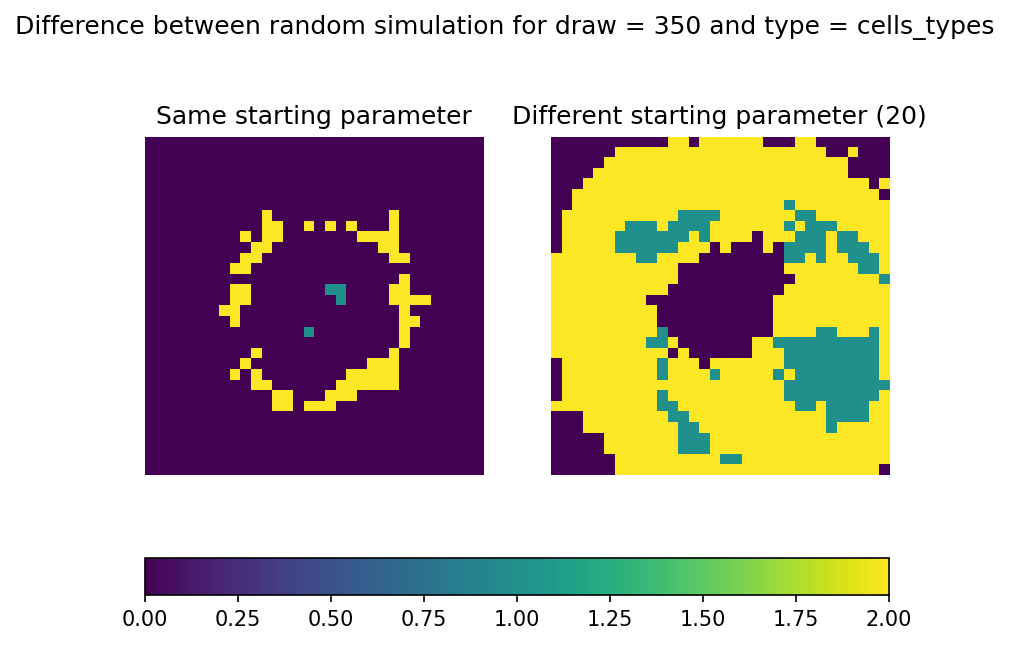

In [193]:
def random_diff_plot(draw, image_type, difference, crop_percentage = 0.5):
    same_index_1, same_index_2 = np.random.choice(comparator.get_all_indexes("cell_cycle",24),2, replace= False)
    diff_param = random.choice(value_that_diff(comparator.get_possible_values("cell_cycle"), difference))
    diff_index_1 = np.random.choice(comparator.get_all_indexes("cell_cycle",diff_param[0]),1, replace= False)[0]
    diff_index_2 = np.random.choice(comparator.get_all_indexes("cell_cycle",diff_param[1]),1, replace= False)[0]
    
    diff_same = comparator.diff(same_index_1, same_index_2, crop_percentage=crop_percentage)[draw][image_type]
    diff_diff = comparator.diff(diff_index_1, diff_index_2, crop_percentage=crop_percentage)[draw][image_type]
    
    fig, axis = plt.subplots(1,2,dpi=150)
    fig.suptitle(f"Difference between random simulation for draw = {draw} and type = {image_type}")
    min_value = min(np.min(diff_same), np.min(diff_diff))
    max_value = max(np.max(diff_same), np.max(diff_diff))
    
    df = pd.DataFrame(columns=["Metric","Same starting parameter","Different starting parameter"])
    df.loc[0] = ["Histogram correlation",comparator.corr_hist(same_index_1,same_index_2, bins = 100, crop_percentage=crop_percentage)[draw][image_type],comparator.corr_hist(diff_index_1,diff_index_2, bins = 100, crop_percentage=crop_percentage)[draw][image_type]]
    df.loc[1] = ["SSIM",comparator.ssim(same_index_1,same_index_2, crop_percentage=crop_percentage)[draw][image_type],comparator.ssim(diff_index_1,diff_index_2, crop_percentage=crop_percentage)[draw][image_type]]
    df.loc[2] = ["Mean absolute error", comparator.mean_absolute_error(same_index_1,same_index_2, crop_percentage=crop_percentage)[draw][image_type],comparator.mean_absolute_error(diff_index_1,diff_index_2, crop_percentage=crop_percentage)[draw][image_type]]
    df.loc[3] = ["Root mean squared error", comparator.root_mean_squared_error(same_index_1,same_index_2, crop_percentage=crop_percentage)[draw][image_type],comparator.root_mean_squared_error(diff_index_1,diff_index_2, crop_percentage=crop_percentage)[draw][image_type]]
    df.loc[4] = ["Max absolute error", comparator.max_absolute_error(same_index_1,same_index_2, crop_percentage=crop_percentage)[draw][image_type],comparator.max_absolute_error(diff_index_1,diff_index_2,crop_percentage=crop_percentage)[draw][image_type]]
    print(df.to_string(index=False))
    
    plotLeft = axis[0].imshow(diff_same,vmin=min_value,vmax=max_value)
    axis[0].set_title("Same starting parameter")
    axis[0].axis("off")
    plotRight = axis[1].imshow(diff_diff, vmin=min_value,vmax=max_value)
    axis[1].set_title(f"Different starting parameter ({difference})")
    axis[1].axis("off")
    fig.colorbar(plotLeft,orientation="horizontal",ax=axis.ravel().tolist())
    plt.show()

random_diff_plot(350, "cells_types", 20, crop_percentage=0.5)

# Mean difference

In [183]:
def mean_diff(draw, image_type, metrics, difference = 0, iteration = 100, crop_percentage=0.5):
    all_pair_param = value_that_diff(comparator.get_possible_values("cell_cycle"), difference)
    all_pair_indexes = []
    for diff in all_pair_param:
        for value1 in comparator.get_all_indexes("cell_cycle",diff[0]):
            for value2 in comparator.get_all_indexes("cell_cycle",diff[1]):
                if value1 != value2:
                    all_pair_indexes.append((value1,value2))
    
    indexes = [np.random.choice(len(all_pair_indexes), iteration, replace=False)][0]
    all_pair_indexes = [all_pair_indexes[i] for i in indexes]
    
    if metrics == "difference":
        return np.mean(np.array([comparator.diff(pair[0], pair[1],crop_percentage=crop_percentage)[draw][image_type] for pair in all_pair_indexes]), axis=0)
    elif metrics == "corr_hist":
        return np.mean(np.array([comparator.corr_hist(pair[0], pair[1],crop_percentage=crop_percentage)[draw][image_type] for pair in all_pair_indexes]), axis=0)
    elif metrics== "ssim":
        return np.mean(np.array([comparator.ssim(pair[0], pair[1],crop_percentage=crop_percentage)[draw][image_type] for pair in all_pair_indexes]), axis=0)
    elif metrics=="mean_absolute_error":
        return np.mean(np.array([comparator.mean_absolute_error(pair[0], pair[1],crop_percentage=crop_percentage)[draw][image_type] for pair in all_pair_indexes]), axis=0)
    elif metrics=="root_mean_squared_error":
        return np.mean(np.array([comparator.root_mean_squared_error(pair[0], pair[1],crop_percentage=crop_percentage)[draw][image_type] for pair in all_pair_indexes]), axis=0)
    elif metrics=="max_absolute_error":
        return np.mean(np.array([comparator.max_absolute_error(pair[0], pair[1],crop_percentage=crop_percentage)[draw][image_type] for pair in all_pair_indexes]), axis=0)
    else:
        return None

## Mean difference image

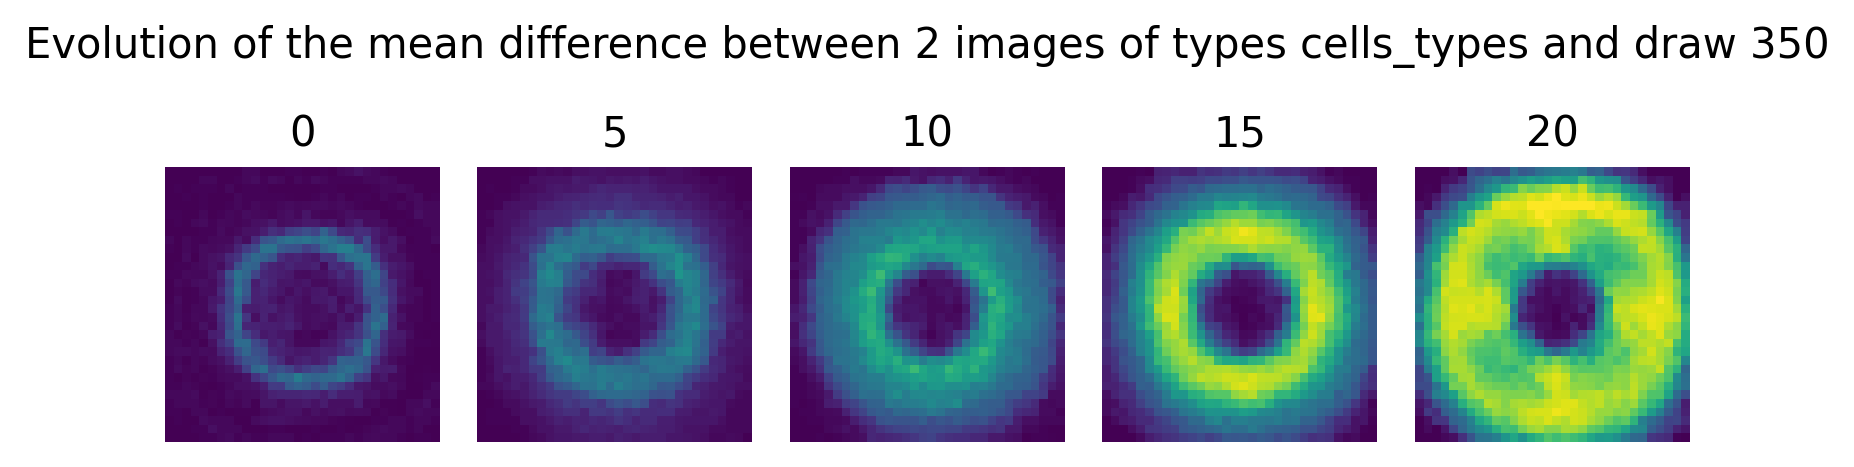

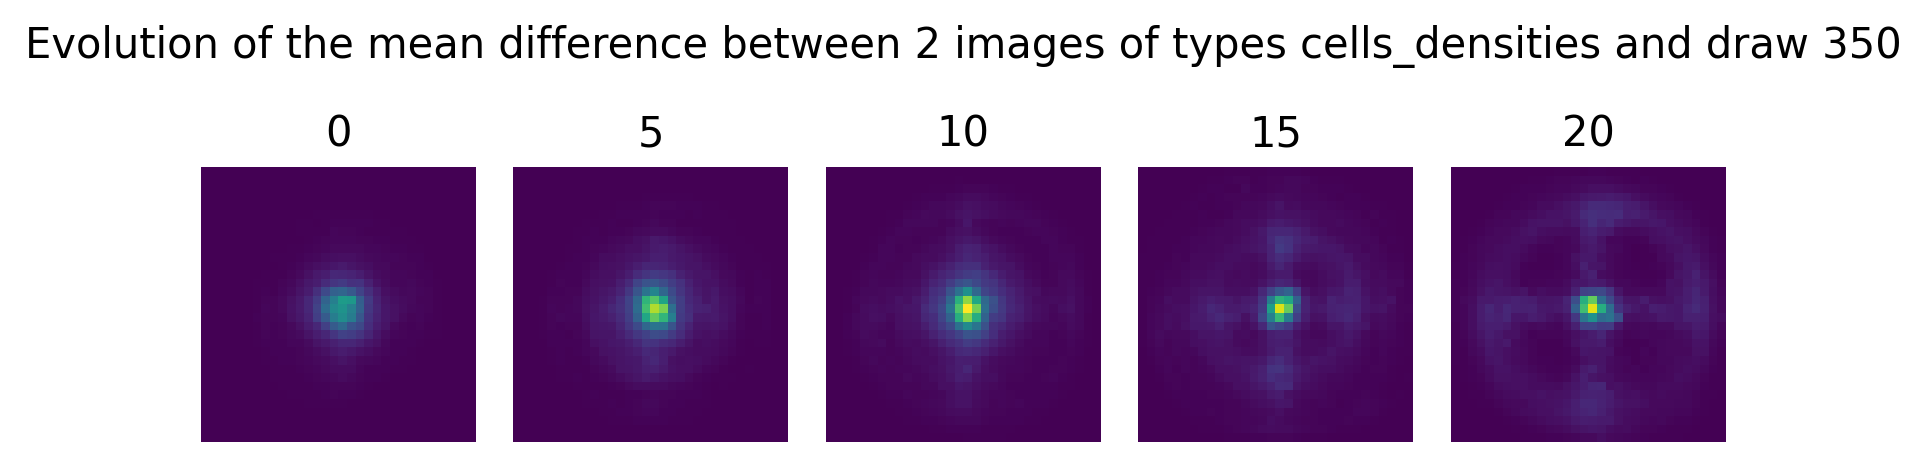

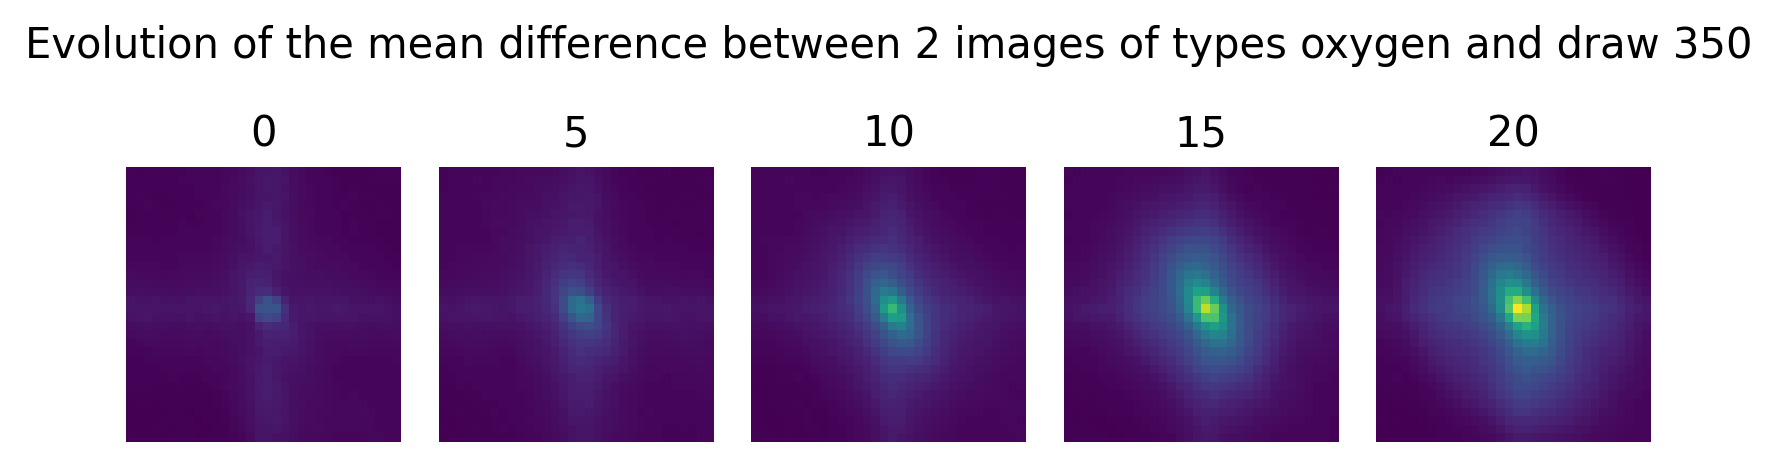

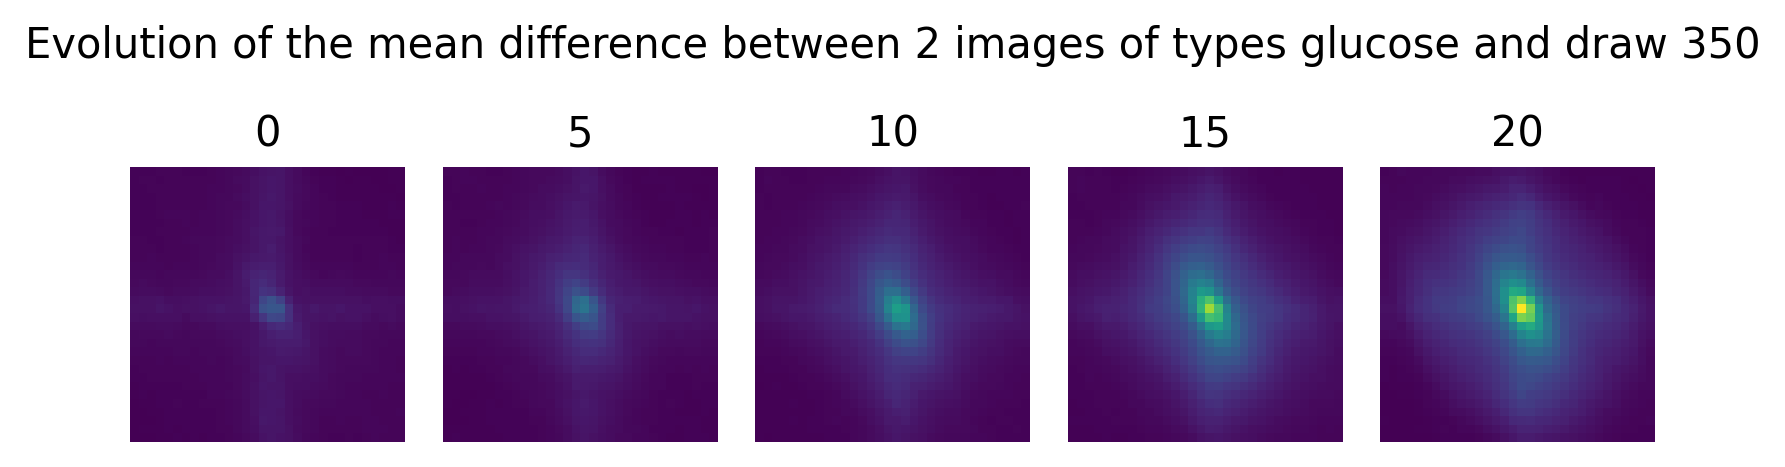

In [184]:
draw = 350
for images_type in ['cells_types', 'cells_densities', 'oxygen', 'glucose']:
    fig, ax = plt.subplots(1,5,dpi=250)
    fig.suptitle(f"Evolution of the mean difference between 2 images of types {images_type} and draw {draw}",y=0.7)
    datas = [mean_diff(draw, images_type, "difference", difference, iteration=100) for difference in [0,5,10,15,20]]
    v_min = np.min(datas)
    v_max = np.max(datas)
    last_plot = None
    for index, difference in enumerate([0,5,10,15,20]):
        ax[index].set_title(f"{difference}")
        last_plot = ax[index].imshow(datas[index], vmin=v_min, vmax=v_max)
        ax[index].axis('off')
    plt.tight_layout()
    plt.savefig(f"Evolution of the mean difference between 2 images of types {images_type}.png", dpi=150,bbox_inches='tight')
    plt.show()

## Mean difference metrics

### First metric: Histogram Correlation (between -1 and 1)
$$\text{Histogram Correlation}(X,Y)=corr(histogram(X),histogram(Y))$$

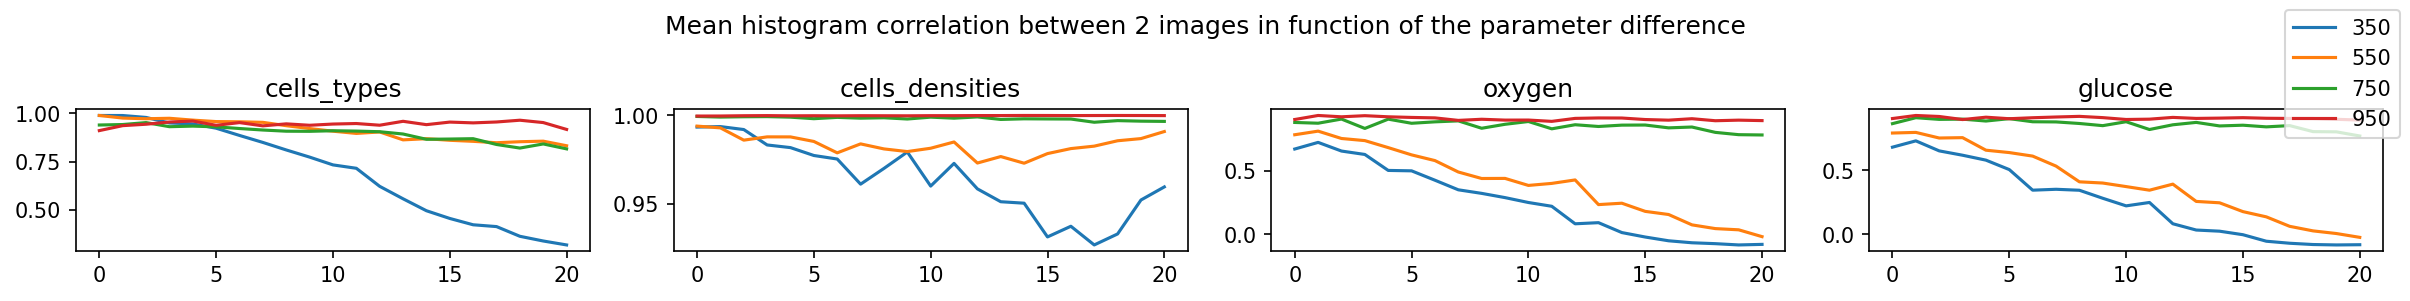

In [210]:
fig, ax = plt.subplots(1,4, dpi=150, figsize=(16,2))
fig.suptitle("Mean histogram correlation between 2 images in function of the parameter difference")
for index, images_type in enumerate(['cells_types', 'cells_densities', 'oxygen', 'glucose']):
    X = range(0,21)
    for draw in [350, 550, 750, 950]:
        Y = [mean_diff(draw, images_type, "corr_hist", diff, iteration=100, crop_percentage=0.3) for diff in X]
        if index == 3:
            ax[index].plot(X,Y,label=draw)
        else:
            ax[index].plot(X,Y)
    ax[index].set_title(f"{images_type}")
fig.tight_layout()
fig.legend()
plt.savefig("Mean histogram correlation between 2 images in function of the parameter difference.png", dpi=150,bbox_inches='tight')
plt.show()

### Second metric: SSIM (Structural Similarity Index Measure) (between -1 and 1)
$$SSIM(X,Y)$$
[[https://en.wikipedia.org/wiki/Structural_similarity_index_measure]]

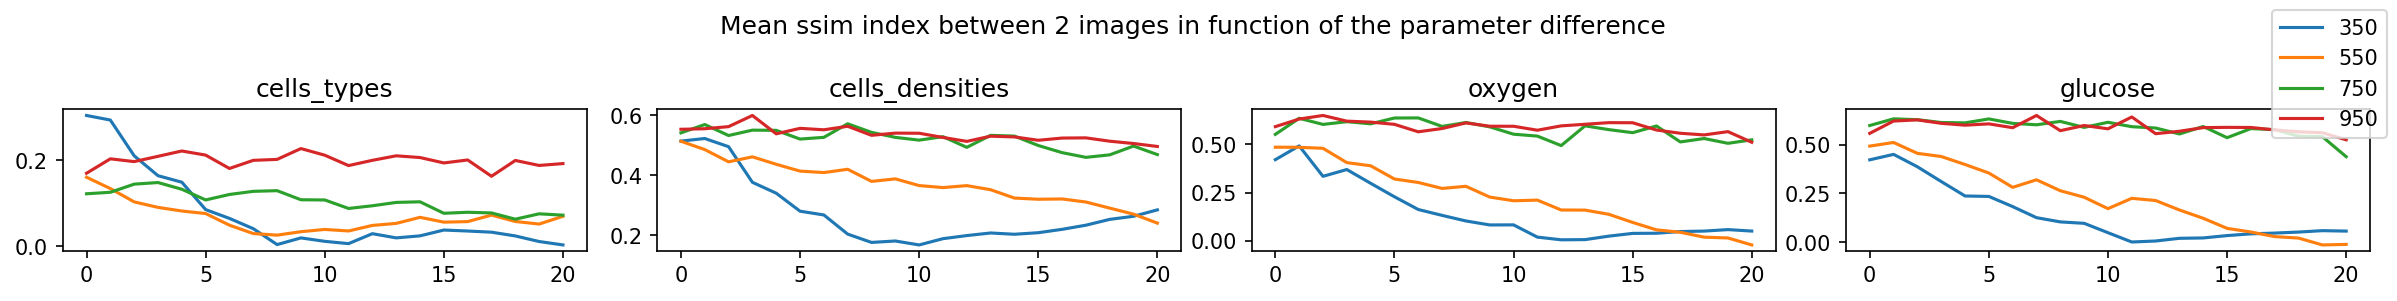

In [212]:
fig, ax = plt.subplots(1,4, dpi=150, figsize=(16,2))
fig.suptitle("Mean ssim index between 2 images in function of the parameter difference")
for index, images_type in enumerate(['cells_types', 'cells_densities', 'oxygen', 'glucose']):
    X = range(0,21)
    for draw in [350, 550, 750, 950]:
        Y = [mean_diff(draw, images_type, "ssim", diff, iteration=100, crop_percentage=0.3) for diff in X]
        if index == 3:
            ax[index].plot(X,Y,label=draw)
        else:
            ax[index].plot(X,Y)
    ax[index].set_title(f"{images_type}")
fig.tight_layout()
fig.legend()
plt.savefig("Mean ssim index between 2 images in function of the parameter difference.png", dpi=150,bbox_inches='tight')
plt.show()

### Third metric: Mean Absolute Error 
$$d_1(X,Y) = \left\| X-Y \right\|_{1} \sim MAE(X,Y)=\frac{1}{Height\cdot Width}\sum_{i}\sum_{j}\left| X_{ij}-Y_{ij} \right|$$
[[https://math.stackexchange.com/questions/507742/distance-similarity-between-two-matrices]]

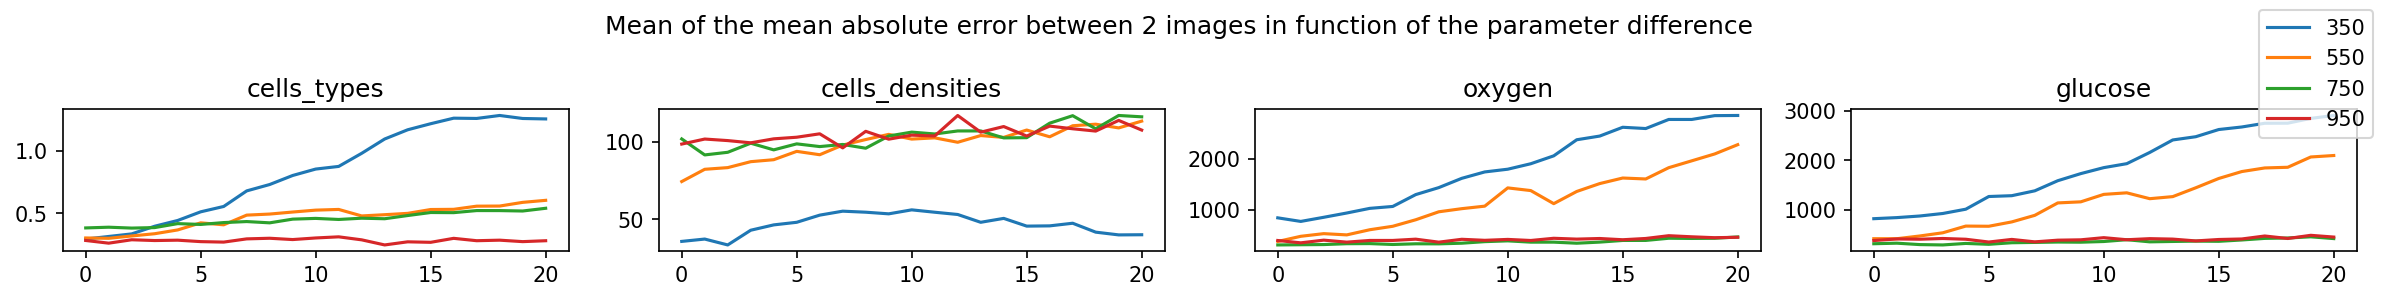

In [213]:
fig, ax = plt.subplots(1,4, dpi=150, figsize=(16,2))
fig.suptitle("Mean of the mean absolute error between 2 images in function of the parameter difference")
for index, images_type in enumerate(['cells_types', 'cells_densities', 'oxygen', 'glucose']):
    X = range(0,21)
    for draw in [350, 550, 750, 950]:
        Y = [mean_diff(draw, images_type, "mean_absolute_error", diff, iteration=100, crop_percentage=0.3) for diff in X]
        if index == 3:
            ax[index].plot(X,Y,label=draw)
        else:
            ax[index].plot(X,Y)
    ax[index].set_title(f"{images_type}")
fig.tight_layout()
fig.legend()
plt.savefig("Mean of the mean absolute error between 2 images in function of the parameter difference.png", dpi=150,bbox_inches='tight')
plt.show()

### Fourth metric: Root Mean Squared Error (RMSE) 
$$d_2(X,Y) = \left\| X-Y \right\|_{2} \sim RMSE(X,Y)= \sqrt{\frac{1}{Height\cdot Width}\sum_{i}\sum_{j}\left( X_{ij}-Y_{ij} \right)^{2} }$$
[[https://math.stackexchange.com/questions/507742/distance-similarity-between-two-matrices]]

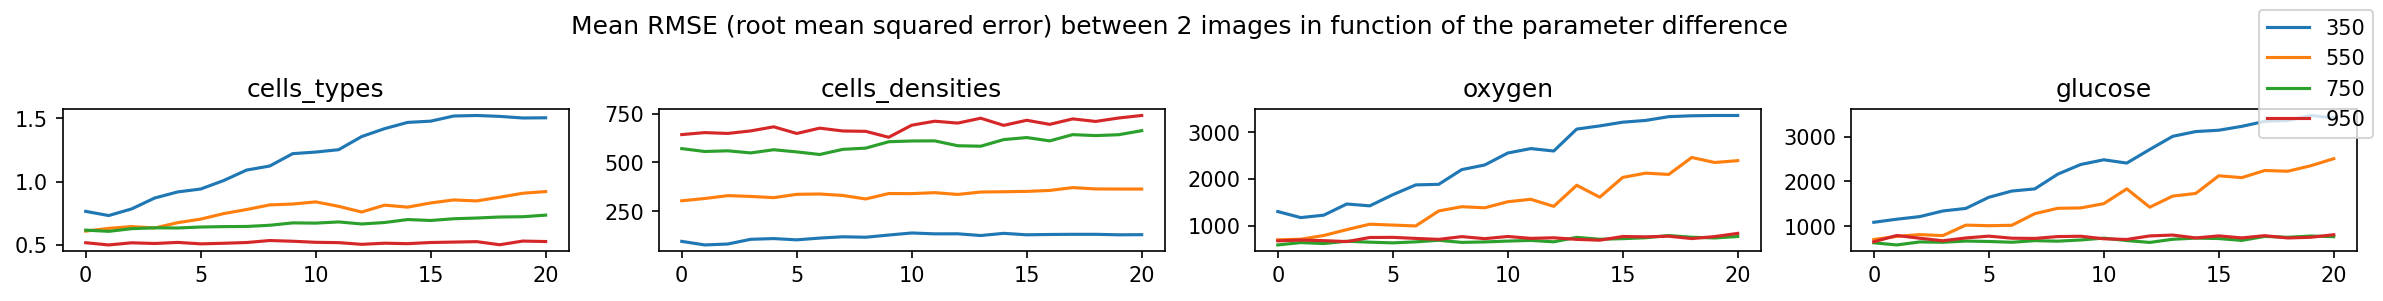

In [214]:
fig, ax = plt.subplots(1,4, dpi=150, figsize=(16,2))
fig.suptitle("Mean RMSE (root mean squared error) between 2 images in function of the parameter difference")
for index, images_type in enumerate(['cells_types', 'cells_densities', 'oxygen', 'glucose']):
    X = range(0,21)
    for draw in [350, 550, 750, 950]:
        Y = [mean_diff(draw, images_type, "root_mean_squared_error", diff, iteration=100, crop_percentage=0.3) for diff in X]
        if index == 3:
            ax[index].plot(X,Y,label=draw)
        else:
            ax[index].plot(X,Y)
    ax[index].set_title(f"{images_type}")
fig.tight_layout()
fig.legend()
plt.savefig("Mean RMSE (root mean squared error) between 2 images in function of the parameter difference.png", dpi=150,bbox_inches='tight')
plt.show()

### Fifth metric: Max Absolute Error
$$d_\infty (X,Y) = \left\| X-Y \right\|_{\infty } \sim MaxAE(X-Y)=\max(X-Y)$$
[[https://math.stackexchange.com/questions/507742/distance-similarity-between-two-matrices]]

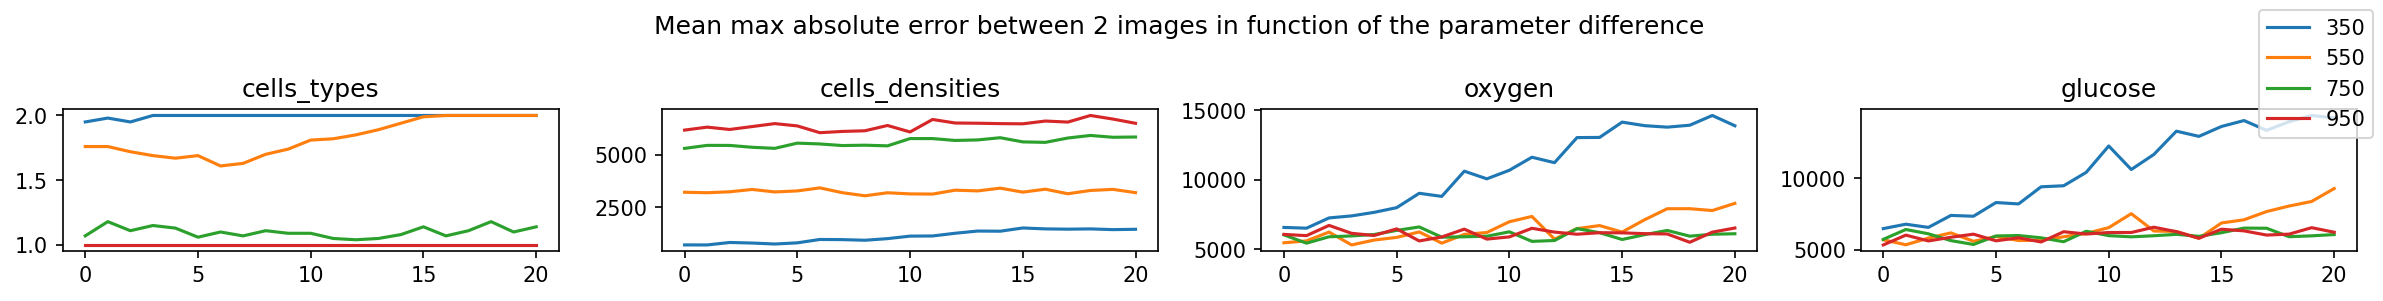

In [215]:
fig, ax = plt.subplots(1,4, dpi=150, figsize=(16,2))
fig.suptitle("Mean max absolute error between 2 images in function of the parameter difference")
for index, images_type in enumerate(['cells_types', 'cells_densities', 'oxygen', 'glucose']):
    X = range(0,21)
    for draw in [350, 550, 750, 950]:
        Y = [mean_diff(draw, images_type, "max_absolute_error", diff, iteration=100, crop_percentage=0.3) for diff in X]
        if index == 3:
            ax[index].plot(X,Y,label=draw)
        else:
            ax[index].plot(X,Y)
    ax[index].set_title(f"{images_type}")
fig.tight_layout()
fig.legend()
plt.savefig("Mean max absolute error between 2 images in function of the parameter difference.png", dpi=150,bbox_inches='tight')
plt.show()